# RAPIDS SVC w/ Feature Engineering
We will train a Linear SVC model and selectively add (non-linear) feature engineered interaction features. We will use forward feature selection to discover which features improve CV score. We will use group k fold with year as group since the test data is different years than train data.

We will use [RAPIDS cuDF][1] for dataframe operations (using `%load_ext cudf.pandas` zero code change magic command which converts all pandas code into cuDF code) and RAPIDS cuML for SVC. Both will run quickly on GPU instead of CPU. Since the data is small it doesn't make too much difference, but if the data was large then we would see a big speed boost. Speed is important when we want to perform lots of experiments in search of ideas to improve our model!

Our simple model achieves `CV=0.893` and `LB=0.856` woohoo! Discussion about this notebook is [here][2]

[1]: https://rapids.ai/cudf-pandas/
[2]: https://www.kaggle.com/competitions/playground-series-s5e3/discussion/568268

In [1]:
%load_ext cudf.pandas
import pandas as pd, numpy as np

train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
train['year_group'] = train['id']//365 
print("Train shape:", train.shape )
train.head()

Train shape: (2190, 14)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,year_group
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,0
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,0
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,0
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,0


In [2]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
test.head()

Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


# Explore Train and Test Data

We will check two things with EDA:
* Verify train distribution is similar to test distribution
* Analyze target relationship to binned features

Regarding (1), if train and test distribution differ, then we will need to transform features so that they are similar and our model can generalize from train to test. Regarding (2), understanding how target relates to features will help us build better models and/or feature engineer.

From EDA below, we see that train distribution and test distribution are similar. This is good. We also see that there are strong correlations between features and targets.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
RMV = ['rainfall','id','bucket','year_group']
FEATURES = [c for c in list( train.columns ) if not c in RMV]
print(f"We have {len(FEATURES)} basic features:")
print( FEATURES )

We have 11 basic features:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


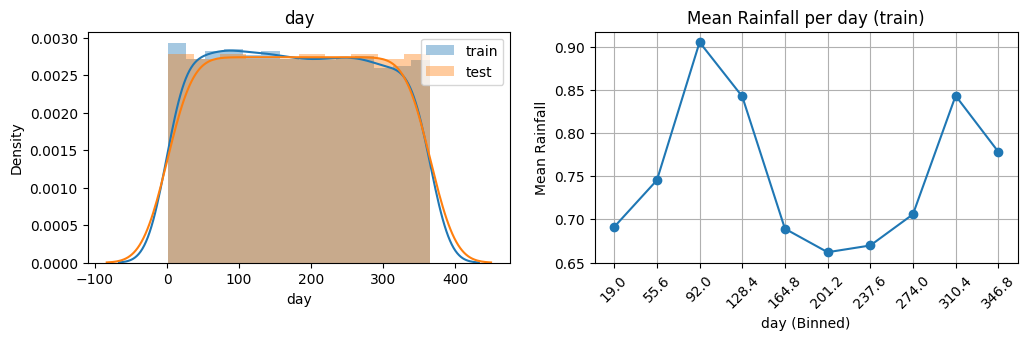

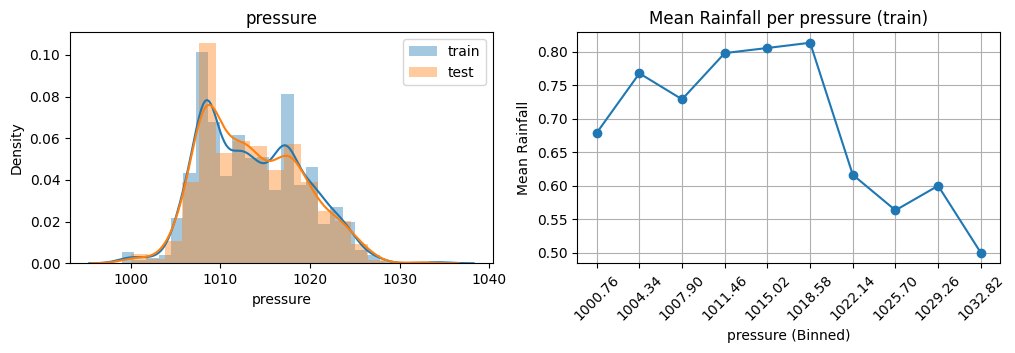

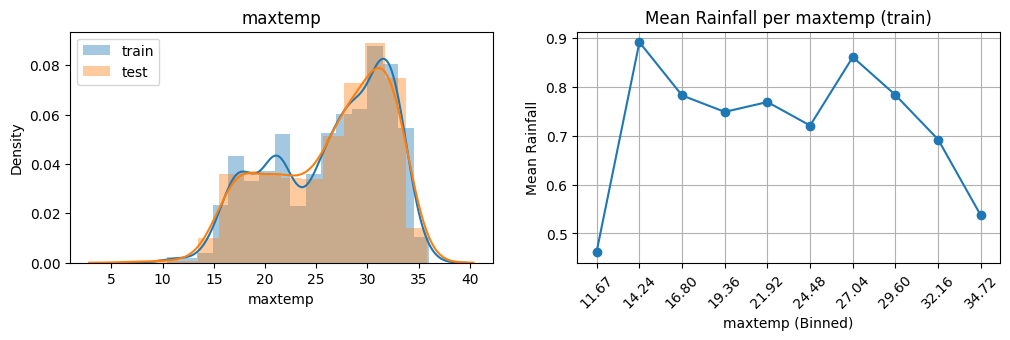

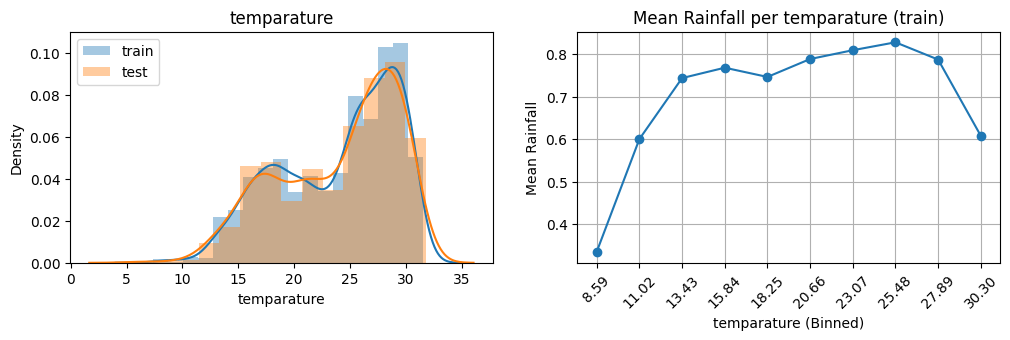

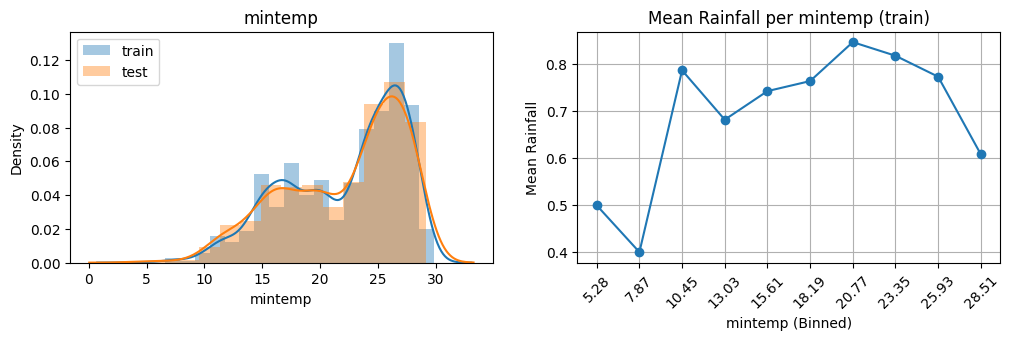

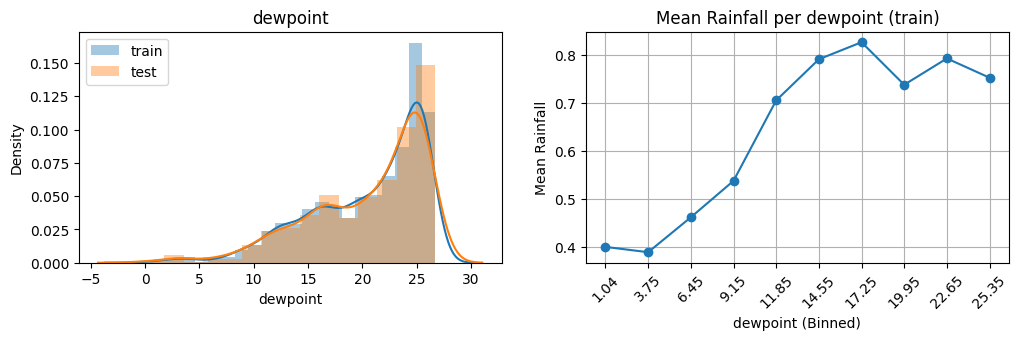

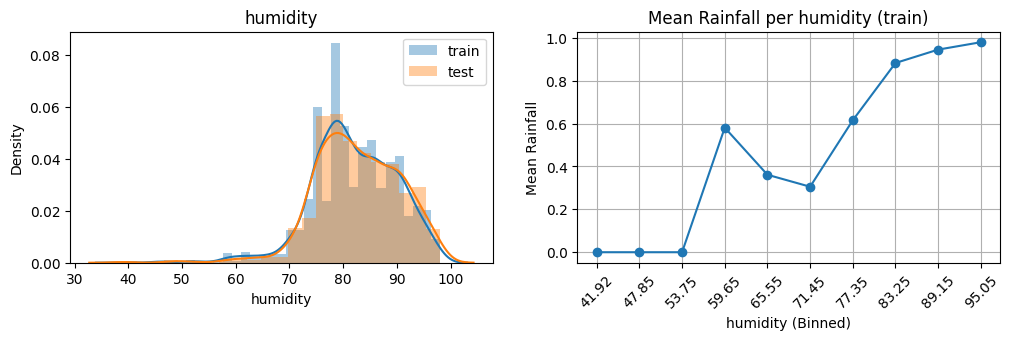

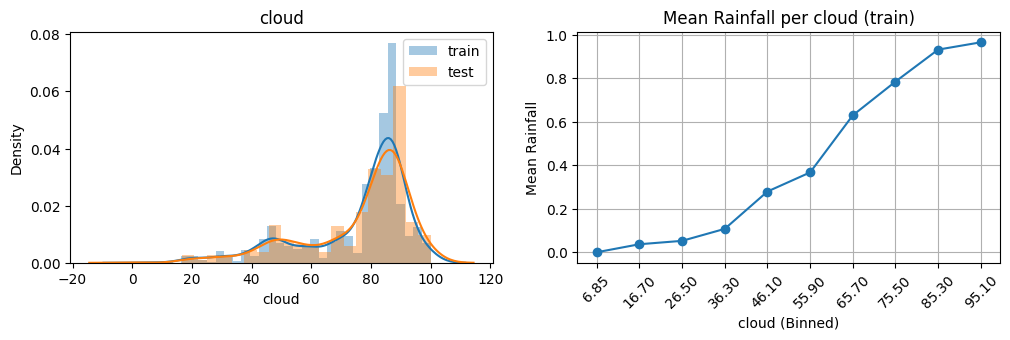

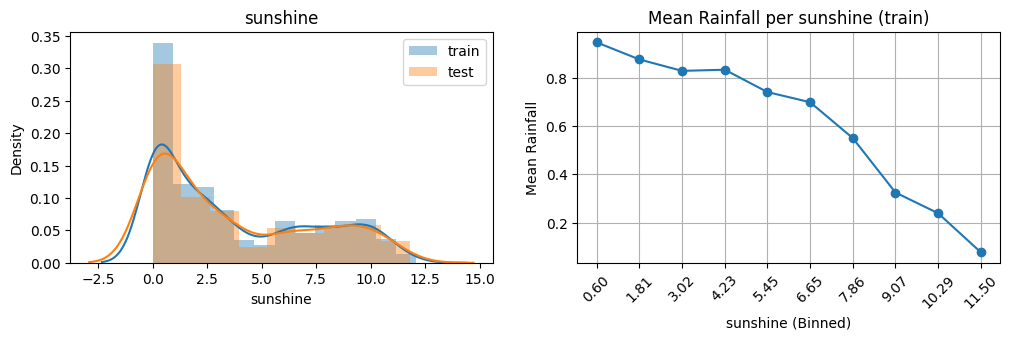

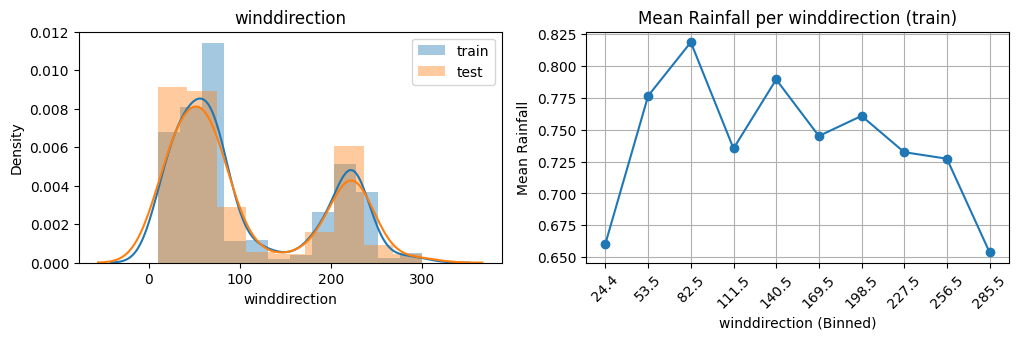

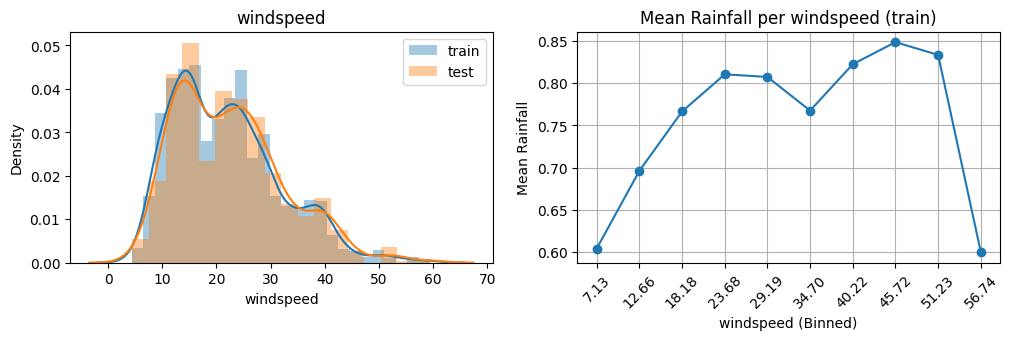

In [5]:
for c in FEATURES:

    # PLOT TRAIN DISTRIBUTION COMPARED WITH TEST DISTRIBUTION
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    sns.distplot(train[c],label='train')
    sns.distplot(test[c],label='test')
    plt.legend()
    plt.title(f"{c}")    

    # PLOT TARGET RELATIONSHIP WITH BINNED NUMERIC FEATURES
    plt.subplot(1,2,2)
    train['bucket'], bin_edges = pd.cut(train[c], bins=10, retbins=True, labels=False)
    bucket_means = train.groupby('bucket')['rainfall'].mean()
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_midpoints, bucket_means, marker='o', linestyle='-')
    plt.xlabel(f'{c} (Binned)')
    plt.ylabel('Mean Rainfall')
    plt.title(f'Mean Rainfall per {c} (train)')
    plt.xticks(bin_midpoints, rotation=45)
    plt.grid()
    
    plt.show()

# RAPIDS SVC w/ Forward Feature Selection
Using the speed up GPU we will iterate though a list of engineered features and train a new model with adding each one by one to our basic features. Whenever a new feature improves our CV score, we will keep it and continue. If the feature does not improve CV score, we will discard it.

Note the model SVC wants all features to have mean=0 and std=1, so we standardize all features inside each of our k fold loops. Since the data is small, we will cautiously avoid overfitting by using a linear SVC model (and we are selectively adding some non-linear engineered features).

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import roc_auc_score
#from sklearn.svm import SVC, LinearSVC
from sklearn.svm import SVC, LinearSVC


In [7]:
INTERACT = []
for i,c1 in enumerate(FEATURES):
    for j,c2 in enumerate(FEATURES[i+1:]):
        n = f"{c1}_{c2}"
        train[n] = train[c1] * train[c2]
        test[n] = test[c1] * test[c2]
        INTERACT.append(n)
print(f"There are {len(INTERACT)} interaction features:")
print( INTERACT )

There are 55 interaction features:
['day_pressure', 'day_maxtemp', 'day_temparature', 'day_mintemp', 'day_dewpoint', 'day_humidity', 'day_cloud', 'day_sunshine', 'day_winddirection', 'day_windspeed', 'pressure_maxtemp', 'pressure_temparature', 'pressure_mintemp', 'pressure_dewpoint', 'pressure_humidity', 'pressure_cloud', 'pressure_sunshine', 'pressure_winddirection', 'pressure_windspeed', 'maxtemp_temparature', 'maxtemp_mintemp', 'maxtemp_dewpoint', 'maxtemp_humidity', 'maxtemp_cloud', 'maxtemp_sunshine', 'maxtemp_winddirection', 'maxtemp_windspeed', 'temparature_mintemp', 'temparature_dewpoint', 'temparature_humidity', 'temparature_cloud', 'temparature_sunshine', 'temparature_winddirection', 'temparature_windspeed', 'mintemp_dewpoint', 'mintemp_humidity', 'mintemp_cloud', 'mintemp_sunshine', 'mintemp_winddirection', 'mintemp_windspeed', 'dewpoint_humidity', 'dewpoint_cloud', 'dewpoint_sunshine', 'dewpoint_winddirection', 'dewpoint_windspeed', 'humidity_cloud', 'humidity_sunshine', 'h

In [ ]:
ADD  = []
best_auc = 0
best_oof = None
best_pred = None

# FORWARD FEATURE SELECTION 
for k, col in enumerate(['baseline'] + INTERACT):

    FOLDS = train.year_group.nunique()
    kf = GroupKFold(n_splits=FOLDS)
    
    oof_svc = np.zeros(len(train))
    pred_svc = np.zeros(len(test))

    if col != 'baseline':
        ADD.append(col)

    for i, (train_index, test_index) in enumerate(kf.split(train, groups=train.year_group)):
        
        x_train = train.loc[train_index, FEATURES + ADD].copy()
        y_train = train.loc[train_index, "rainfall"]
        x_valid = train.loc[test_index, FEATURES + ADD].copy()
        y_valid = train.loc[test_index, "rainfall"]
        x_test = test[FEATURES + ADD].copy()

        # Standardize features
        for c in FEATURES + ADD:
            m = x_train[c].mean()
            s = x_train[c].std()
            x_train[c] = (x_train[c] - m) / s
            x_valid[c] = (x_valid[c] - m) / s
            x_test[c] = (x_test[c] - m) / s
            x_test[c] = x_test[c].fillna(0)

        # Train SVC model
        model = LinearSVC(C=0.1)
        model.fit(x_train.values, y_train.values)

        # Use decision_function instead of predict_proba
        oof_svc[test_index] = model.decision_function(x_valid.values)
        pred_svc += model.decision_function(x_test.values)

    pred_svc /= FOLDS

    # Normalize decision scores for AUC
    true = train.rainfall.values
    m = roc_auc_score(true, oof_svc)

    if m > best_auc:
        print(f"NEW BEST with {col} at {m}")
        best_auc = m
        best_oof = oof_svc.copy()
        best_pred = pred_svc.copy()
    else:
        print(f"Worse with {col} at {m}")
        ADD.remove(col)


NEW BEST with baseline at 0.8915555555555554
Worse with day_pressure at 0.8915117845117845
Worse with day_maxtemp at 0.8913995510662178
Worse with day_temparature at 0.89141189674523
Worse with day_mintemp at 0.891398428731762
Worse with day_dewpoint at 0.891452300785634
Worse with day_humidity at 0.891320987654321
Worse with day_cloud at 0.8909674523007857
NEW BEST with day_sunshine at 0.891973063973064
NEW BEST with day_winddirection at 0.8923737373737373
Worse with day_windspeed at 0.8922480359147025
Worse with pressure_maxtemp at 0.892077441077441
Worse with pressure_temparature at 0.8921851851851852
Worse with pressure_mintemp at 0.892283950617284
Worse with pressure_dewpoint at 0.8922008978675645
Worse with pressure_humidity at 0.8919113355780023
Worse with pressure_cloud at 0.8917586980920313
Worse with pressure_sunshine at 0.8922143658810326
Worse with pressure_winddirection at 0.8920437710437711
Worse with pressure_windspeed at 0.8923400673400673
Worse with maxtemp_temparature

In [9]:
print(f"We achieved CV SVC AUC = {best_auc:.4f} adding {len(ADD)} interactions features:")
print( ADD )

We achieved CV SVC AUC = 0.8933 adding 12 interactions features:
['day_sunshine', 'day_winddirection', 'maxtemp_cloud', 'maxtemp_sunshine', 'maxtemp_windspeed', 'temparature_dewpoint', 'temparature_humidity', 'temparature_cloud', 'dewpoint_winddirection', 'dewpoint_windspeed', 'humidity_winddirection', 'humidity_windspeed']


# Create Submission CSV
We will make a submission CSV using our best SVC model with all the engineered features that improved our CV score!

In [10]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = best_pred
print("Submission shape:", sub.shape )
sub.to_csv(f"submission.csv",index=False)
sub.head()

Submission shape: (730, 2)


,id,rainfall
0,2190,0.974903
1,2191,0.976795
2,2192,0.926142
3,2193,0.074103
4,2194,0.058337
